In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os 

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.20.0


In [4]:
base_dir = r'C:\Users\Lenovo\Desktop\tumor_otak' 

train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

print("Training directory:", train_dir)
print("Testing directory:", test_dir)
print("Is training dir valid?", os.path.isdir(train_dir))
print("Is testing dir valid?", os.path.isdir(test_dir))

Training directory: C:\Users\Lenovo\Desktop\tumor_otak\Training
Testing directory: C:\Users\Lenovo\Desktop\tumor_otak\Testing
Is training dir valid? True
Is testing dir valid? True


In [5]:
# Sel 3: Setup Image Data Generators

IMG_SIZE = (224, 224) 
BATCH_SIZE = 32 

# Untuk data training: kita lakukan augmentasi 
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Untuk data testing: kita HANYA lakukan normalisasi
test_datagen = ImageDataGenerator(
    rescale=1./255 # Normalisasi piksel 
)

# Muat gambar dari direktori
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Karena kita punya > 2 kelas
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

# Cek kelas yang ditemukan
print("Kelas yang ditemukan:", train_generator.class_indices)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Kelas yang ditemukan: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [6]:
# Sel 4: Bangun Model Transfer Learning

# Muat base model MobileNetV2, tanpa lapisan atas (include_top=False)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Bekukan lapisan base model agar tidak ikut berlatih ulang 
base_model.trainable = False

# Tambahkan lapisan klasifikasi kita 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x) # Dropout untuk mengurangi overfitting

# Lapisan output. '4' adalah jumlah kelas Anda.
# Gunakan 'softmax' untuk klasifikasi multi-kelas
predictions = Dense(4, activation='softmax')(x) 

# Gabungkan menjadi model utuh
model = Model(inputs=base_model.input, outputs=predictions)

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy', # Cocok untuk klasifikasi multi-kelas
    metrics=['accuracy']
)

# Lihat arsitektur model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# Sel 5: Latih Model

EPOCHS = 70 # Anda bisa mulai dengan 10, lalu tambah jika hasilnya kurang

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

Epoch 1/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 80s 812ms/step - accuracy: 0.6794 - loss: 0.7852 - val_accuracy: 0.5286 - val_loss: 1.3536
Epoch 2/70
 1/89 ━━━━━━━━━━━━━━━━━━━━ 47s 545ms/step - accuracy: 0.7812 - loss: 0.5302

c:\Users\Lenovo\Desktop\tumor_otak\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.7812 - loss: 0.5302 - val_accuracy: 0.5365 - val_loss: 1.3614
Epoch 3/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 73s 816ms/step - accuracy: 0.7992 - loss: 0.5175 - val_accuracy: 0.5495 - val_loss: 1.5475
Epoch 4/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8438 - loss: 0.4965 - val_accuracy: 0.5391 - val_loss: 1.5658
Epoch 5/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 72s 809ms/step - accuracy: 0.8238 - loss: 0.4504 - val_accuracy: 0.5443 - val_loss: 1.4770
Epoch 6/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.8750 - loss: 0.2553 - val_accuracy: 0.5521 - val_loss: 1.4348
Epoch 7/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 911ms/step - accuracy: 0.8383 - loss: 0.4259 - val_accuracy: 0.5807 - val_loss: 1.3851
Epoch 8/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9375 - loss: 0.3857 - val_accuracy: 0.5859 - val_loss: 1.3956
Epoch 9/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 826ms/step - accuracy: 0.8531 - loss: 0.3855 - val_accuracy: 0.5833 - val_


Mengevaluasi model pada data tes...
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 526ms/step - accuracy: 0.7386 - loss: 1.3593
Akurasi pada data tes: 73.86%


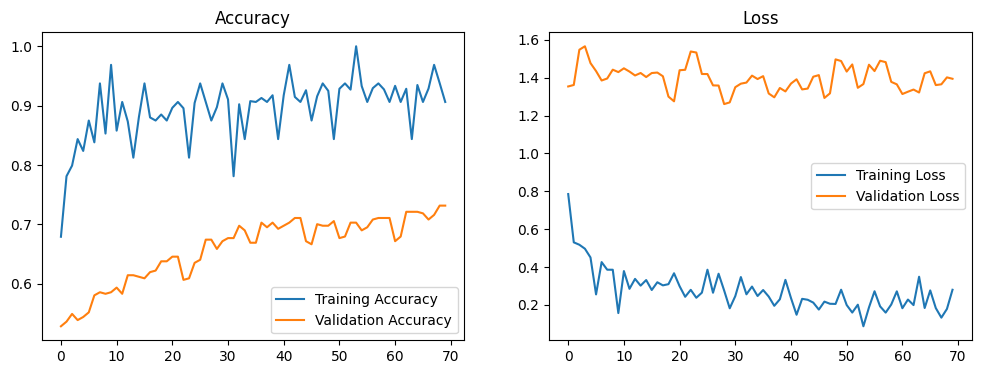

In [8]:
# Sel 6: Evaluasi Model
print("\nMengevaluasi model pada data tes...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi pada data tes: {test_acc*100:.2f}%")

# (Opsional) Visualisasi Hasil Training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [9]:
# Sel 7: Simpan Model!

model_filename = 'model.h5'
model.save(model_filename)

print(f"\nModel telah berhasil disimpan sebagai {model_filename}")


Model telah berhasil disimpan sebagai model.h5
